In [69]:
import base64
from typing import Annotated, List, Union

# import magic
import requests
from IPython.display import Image, display
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


from typing import Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from langchain_core.tools import tool
from langchain_core.tools.base import ArgsSchema
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
# from ultralytics import YOLO

In [70]:
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

## Tools

In [71]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=2, doc_content_chars_max=1000
)
arxiv = ArxivQueryRun(
    api_wrapper=arxiv_wrapper,
    description="Search for papers on a given topic using Arxiv"
)
arxiv.invoke("Rotary Positional Encoding")
wikipedia_wrapper = WikipediaAPIWrapper()
wikipedia = WikipediaQueryRun(
    api_wrapper=wikipedia_wrapper,
    description="Search for information on a given topic using Wikipedia"
)
wikipedia.invoke("machine learning")
duck_search = DuckDuckGoSearchResults(output_format="list")
duck_search.invoke("Rotary Positional Encoding")

[{'snippet': 'Unlike traditional positional embeddings, such as sinusoidal encodings used in transformers, which represent the absolute positions of tokens, Rotary Positional Embeddings (RoPE) are designed...',
  'title': 'A Deep Dive into Rotary Positional Embeddings (RoPE): Theory and ...',
  'link': 'https://medium.com/@parulsharmmaa/understanding-rotary-positional-embedding-and-implementation-9f4ad8b03e32'},
 {'snippet': 'One of the most popular types of encoding used today in LLMs are Rotary Positional Encodings (RoPE), that rotate the queries and keys based on their relative distance. A common belief is that RoPE is useful because it helps to decay token dependency as relative distance increases.',
  'title': '[2410.06205] Round and Round We Go! What makes Rotary Positional ...',
  'link': 'https://arxiv.org/abs/2410.06205'},
 {'snippet': 'The nn.Embedding layer acts as a lookup table mapping integer indices to vectors of dimension dim.In the forward() function, the positions ten

In [72]:
tools = [arxiv, wikipedia, duck_search]
tools_by_name = {tool.name: tool for tool in tools}

tools_by_name

{'arxiv': ArxivQueryRun(description='Search for papers on a given topic using Arxiv', api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=1000)),
 'wikipedia': WikipediaQueryRun(description='Search for information on a given topic using Wikipedia', api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\Asus\\Ungdung\\Miniconda\\workspace\\envs\\learn_langraph\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)),
 'duckduckgo_results_json': DuckDuckGoSearchResults(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'), output_format='list')}

## Generate Agent

### State

In [73]:
class Analyst(BaseModel):
    name: str = Field(
        description="Name of the analyst."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    tools: List[str]
    
    @property
    def affiliation(self) -> str:
        return f"{self.name} Agent for VQA"
    
    @property
    def persona(self) -> str:
        return f"Name: {self.affiliation}\nTools: {self.tools}\nDescription: {self.description}"

In [74]:
class GenerateAnalystsState(TypedDict):
    question: str
    image: str
    analysts: List[Analyst] 

### Node

In [75]:
def create_analysts(state: GenerateAnalystsState):
    analyst_specs = {
        "junior": {
            "name": "Junior",
            "description": "A junior analyst who uses only the vanilla VQA model to generate candidate answers.",
            "tools": ["arxiv"]
        },
        "senior": {
            "name": "Senior",
            "description": "A senior analyst who uses both the VQA model and KB retrieval to enhance answers.",
            "tools": ["arxiv", "wikipedia"]
        },
        "manager": {
            "name": "Manager",
            "description": "A manager analyst with access to all tools including LLM-based knowledge generation.",
            "tools": ["arxiv", "wikipedia", "duckduckgo_results_json"]
        }
    }

    # Tạo list các Analyst object
    analysts = [Analyst(**spec) for spec in analyst_specs.values()]

    return {"analysts": analysts}

### Build graph

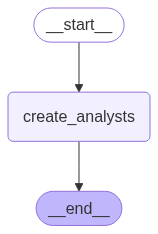

In [76]:
# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", END)

# Compile
memory = MemorySaver()
gen_analysis_graph = builder.compile(checkpointer=memory)

# View
display(Image(gen_analysis_graph.get_graph(xray=1).draw_mermaid_png()))

In [77]:
thread = {"configurable": {"thread_id": "1"}}
analysts = gen_analysis_graph.invoke({"question": "What color is the dog's fur?"}, thread)

In [78]:
analysts["analysts"][2]

Analyst(name='Manager', description='A manager analyst with access to all tools including LLM-based knowledge generation.', tools=['arxiv', 'wikipedia', 'duckduckgo_results_json'])

## Visual-research Agent

### State

In [79]:
class ViReAgentState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: Optional[str] = ""
    LLM_Knowledge: Optional[str] = ""
    KBs_Knowledge: Optional[List[str]] = []

### Node

In [80]:
from langchain_core.runnables import RunnableConfig
import json
from langchain_core.messages import ToolMessage


# Define our tool node
def tool_node(state: ViReAgentState):
    outputs = []
    print(state["messages"][-1].tool_calls)
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_vire_agent(
    state: ViReAgentState,
    config: RunnableConfig,
):
    tools = state["analyst"].tools
    tools = [tools_by_name[tool] for tool in tools]
    llm: ChatOpenAI = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0,
        api_key="not-needed"
    ).bind_tools(tools)
    system_prompt = SystemMessage(
        content=(
            f"You are a {state['analyst'].affiliation}.\n\n"
            "INSTRUCTIONS:\n"
            "- Assist ONLY with research-related tasks, DO NOT do any math\n"
            "- After you're done with your tasks, respond to the supervisor directly\n"
            "- Respond ONLY with the results of your work, do NOT include ANY other text."
        )
    )
    question_prompt = HumanMessage(content=f"question: {state['question']}")
    history = state.get("messages", [])
    sequence = [system_prompt, question_prompt] + history

    response = llm.invoke(sequence, config)
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: ViReAgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

### Graph

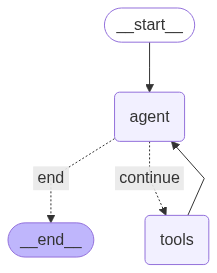

In [81]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Define a new graph
workflow = StateGraph(ViReAgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_vire_agent)
workflow.add_node("tools", tool_node)

# Set start node : start -> agent
workflow.set_entry_point("agent")
# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# We now add a normal edge from ‘tools‘ to ‘agent‘.
# This means that after ‘tools‘ is called, ‘agent‘ node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
ViReAgent = workflow.compile()
display(Image(ViReAgent.get_graph().draw_mermaid_png()))

In [82]:
agent = analysts["analysts"][2]
# Create our initial message dictionary
# "messages": [("user", "How is the weather in Vietnam?")] (optional)
inputs = {"analyst": agent, "question": "How is the weather in Vietnam?"}

for state in ViReAgent.stream(inputs, stream_mode="values"):

    if state["messages"]:
        last_message = state["messages"][-1]
        last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (525454551)
 Call ID: 525454551
  Args:
    query: current weather in Vietnam
[{'name': 'duckduckgo_results_json', 'args': {'query': 'current weather in Vietnam'}, 'id': '525454551', 'type': 'tool_call'}]
================================= Tool Message =================================
Name: duckduckgo_results_json

[{"snippet": "The weather today in Vietnam will be very hot with temperatures reaching 34 \u00b0 C. During the evening and night time the temperatures will drop to 26 \u00b0 C. For deep dive information check out our hourly weather forecast for today down the page.", "title": "Vietnam local weather (live): today, hourly weather", "link": "https://www.weather25.com/asia/vietnam?page=today"}, {"snippet": "Vietnam - Detailed weather forecast for today. Comprehensive weather report for today for all locations.", "title": "Weather today - Vietnam", "link": "https